# Pulmonary Risks - CIS-700 Project

### COVID-19 pulmonary risks CIS-700 Project
- author = {Gerry Wolfe, Will Schreiber, Ashraf Elnashar}
- title = {COVID-19 pulmonary risks literature clustering}
- year = {2020}
- month = {June}
- location = {Syracuse University, USA}

# Loading Data


## Loading Dataset

In [1]:
# !pip3 install langdetect
# !pip3 install spacy
# !pip3 install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
# !pip3 install scispacy
# !pip3 install plotly
# !pip3 install pickle5
# !pip3 install pydotplus
# !pip3 install requests
# !pip3 install beautifulsoup4

In [2]:
import warnings
warnings.filterwarnings("ignore")

from project_template_code import *
import requests
import seaborn as sn
import bs4
import csv
import tensorflow as tf
import pandas as pd

import numpy as np
import glob
import json
import matplotlib.pyplot as plt

import pickle5 as pickle
import datetime

plt.style.use('ggplot')

## Load MetaData
Provides the schema and information from the metadata csv.

In [3]:
# pickle read meta_df

meta_df = read_pickles('meta_df', '2020-05-30')
meta_df.head()
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47298 entries, 0 to 47297
Data columns (total 18 columns):
cord_uid                       47298 non-null object
sha                            34283 non-null object
source_x                       47298 non-null object
title                          47140 non-null object
doi                            43956 non-null object
pmcid                          28038 non-null object
pubmed_id                      35409 non-null object
license                        47298 non-null object
abstract                       39048 non-null object
publish_time                   47289 non-null object
authors                        45189 non-null object
journal                        42894 non-null object
Microsoft Academic Paper ID    964 non-null object
WHO #Covidence                 1768 non-null object
has_pdf_parse                  47298 non-null bool
has_pmc_xml_parse              47298 non-null bool
full_text_file                 38469 non-null obje

## Load JSON

In [4]:
# pickle read all_json

all_json = read_pickles('all_json', '2020-05-30')
len(all_json)

52097

## Build DataFrame from JSON

In [5]:
# pickle read df_covid

df_covid = read_pickles('df_covid', '2020-05-30')
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,0015023cc06b5362d332b3baf348d11567ca2fbb,10.1101/2020.01.10.901801,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes. Chris<...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...
1,00340eea543336d54adda18236424de6a5e91c9d,10.1101/2020.03.16.20034470,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini. Costanza Manes...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir..."
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,10.1101/2020.02.11.20022111,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang. Kaichen Tang. <br...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.
3,00911cf4f99a3d5ae5e5b787675646a743574496,10.1101/2020.03.26.009001,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,CHEER: hierarCHical taxonomic<br>classificati...,NaN,The fast accumulation of viral metagenomic<br...
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,10.1101/634600,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood. Jian Zhang....,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...


### Feature Engineering
Adding word count columns for both abstract and body_text can be useful parameters later.

In [6]:
df_covid['body_unique_words']=get_wordcount(df_covid, 'body_text', True)  # number of unique words in body
print(df_covid['body_unique_words'])

0         705
1        1072
2         377
3        1354
4        1185
         ... 
32412    1529
32413    1414
32414     512
32415    1927
32416    1743
Name: body_unique_words, Length: 32417, dtype: int64


In [7]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32417 entries, 0 to 32416
Data columns (total 9 columns):
paper_id             32417 non-null object
doi                  32103 non-null object
abstract             32417 non-null object
body_text            32417 non-null object
authors              31847 non-null object
title                32381 non-null object
journal              31003 non-null object
abstract_summary     32417 non-null object
body_unique_words    32417 non-null int64
dtypes: int64(1), object(8)
memory usage: 2.2+ MB


In [8]:
df_covid['body_text'].describe(include='all')

count                                                 32417
unique                                                32401
top       In previous reports, workers have characterize...
freq                                                      4
Name: body_text, dtype: object

### Languages
we need to determine the language of each paper in the dataframe. 

In [9]:
# pickle read languages

languages = read_pickles('languages', '2020-05-30')
len(languages)

32417

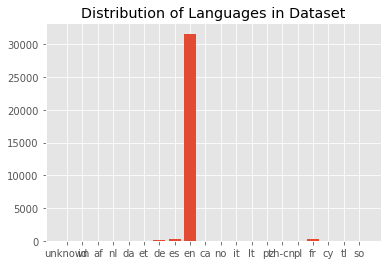

In [10]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

We will be dropping any language that is not English. 

## Data Pre-Processing

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords

In [11]:
# pickle read df

df_covid_processed_data = read_pickles('df', '2020-05-30')
df_covid_processed_data.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_body_text_sample,processed_abstract_sample
0,0015023cc06b5362d332b3baf348d11567ca2fbb,10.1101/2020.01.10.901801,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes. Chris<...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...,241,1728,705,en,vp3 vp0 far process vp2 vp4 virus assembly 6 p...,word count 194 22 text word count 5168 23 24 2...
1,00340eea543336d54adda18236424de6a5e91c9d,10.1101/2020.03.16.20034470,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini. Costanza Manes...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir...",175,2549,1072,en,december 2019 novel coronavirus sars-cov-2 ide...,past month new coronavirus sars-cov-2 epidemic...
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,10.1101/2020.02.11.20022111,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang. Kaichen Tang. <br...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.,0,755,377,en,2019-ncov epidemic spread china 24 country 1 3...,
3,00911cf4f99a3d5ae5e5b787675646a743574496,10.1101/2020.03.26.009001,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,CHEER: hierarCHical taxonomic<br>classificati...,NaN,The fast accumulation of viral metagenomic<br...,139,5188,1354,en,metagenomic sequence allow directly obtain tot...,fast accumulation viral metagenomic datum cont...
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,10.1101/634600,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood. Jian Zhang....,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...,1647,4003,1185,en,infectious bronchitis ib cause infectious bron...,infectious bronchitis ib cause significant eco...


## Text Analysis - Natural Language Processing

In [12]:
text = """
Myeloid derived suppressor cells (MDSC) are immature 
myeloid cells with immunosuppressive activity. 
They accumulate in tumor-bearing mice and humans 
with different types of cancer, including hepatocellular 
carcinoma (HCC).
"""
dependency_parser_visualizer(text)

[
Myeloid derived suppressor cells (MDSC) are immature 
myeloid cells with immunosuppressive activity. 
, They accumulate in tumor-bearing mice and humans 
with different types of cancer, including hepatocellular 
carcinoma (HCC).
]
(Myeloid, suppressor cells, MDSC, immature, myeloid cells, immunosuppressive activity, accumulate, tumor-bearing mice, humans, cancer, hepatocellular 
carcinoma, HCC)


In [13]:
# Pickled

# similarities = similarize_tokens(smoking_synonyms, df_covid_processed_data, 'processed_body_text_sample')

In [14]:
# # pickle write similarities

# date_of_launch = str(datetime.date.today())
# fileObject = open('pickled_token_similarity' + date_of_launch + '.pickle', 'wb')
# pickle.dump(similarities, fileObject)
# fileObject.close()

In [15]:
# pickle read token_similarity
fileObject = open('pickled_token_similarity2020-05-30.pickle', 'rb')
token_similarity = pickle.load(fileObject)
fileObject.close()
token_similarity

[{'token1': 'smoking', 'token2': 'string', 'similarity': 0.50300586},
 {'token1': 'smoking', 'token2': 'string', 'similarity': 0.5790452},
 {'token1': 'smoking', 'token2': 'coronavirus', 'similarity': 0.5012743},
 {'token1': 'smoking', 'token2': 'affiliation', 'similarity': 0.52276605},
 {'token1': 'smoking', 'token2': 'consensus', 'similarity': 0.51122606},
 {'token1': 'smoking', 'token2': 'affiliation', 'similarity': 0.5377197},
 {'token1': 'smoking', 'token2': 'knowledge', 'similarity': 0.5069043},
 {'token1': 'smoking', 'token2': 'case', 'similarity': 0.50064147},
 {'token1': 'smoking', 'token2': 'study', 'similarity': 0.5149614},
 {'token1': 'smoking', 'token2': 'case', 'similarity': 0.52925795},
 {'token1': 'smoking', 'token2': 'finding', 'similarity': 0.65574074},
 {'token1': 'smoking', 'token2': 'epidemiology', 'similarity': 0.50094146},
 {'token1': 'smoking', 'token2': 'repurposing', 'similarity': 0.537018},
 {'token1': 'smoking', 'token2': 'saturation', 'similarity': 0.558787

In [16]:
df_token_similarity = pd.DataFrame(token_similarity)
df_token_similarity

,token1,token2,similarity
0,smoking,string,0.503006
1,smoking,string,0.579045
2,smoking,coronavirus,0.501274
3,smoking,affiliation,0.522766
4,smoking,consensus,0.511226
...,...,...,...
586,marijuana,china,0.620066
587,marijuana,usa,0.527348
588,marijuana,january,0.537811
589,marijuana,china,0.528132


In [17]:
df_token_similarity['similarity_max'] = df_token_similarity.groupby(['token1'])['similarity'].transform(max)

In [18]:
index = df_token_similarity.groupby(['token1'])['similarity'].transform(max) == df_token_similarity['similarity']
df_token_similarity[index]

,token1,token2,similarity,similarity_max
10,smoking,finding,0.655741,0.655741
96,smoke,report,0.691356,0.691356
203,cigar,disease,0.721474,0.721474
508,nicotine,usa,0.649452,0.649452
532,cannabis,llc,0.588629,0.588629
547,marijuana,coronavirus,0.644733,0.644733


In [19]:
body_text_sample = df_covid['body_text'].values

In [20]:
# # pickle

# body_text_sample = df_covid['body_text'].values
# X1_vectors = vectorize(body_text_sample, 2 ** 12)
# # Train split X1 80/20 X1_Train = X1[0:80%len(body_text)] etc.
# print(X1_vectors[0])

In [21]:
# # pickle write X1_vectors

# date_of_launch = str(datetime.date.today())
# fileObject = open('pickled_X1' + date_of_launch + '.pickle', 'wb')
# pickle.dump(X1_vectors, fileObject)
# fileObject.close()

In [22]:
# pickle read X1_vectors
fileObject = open('pickled_X12020-05-31.pickle', 'rb')
X1_vectors = pickle.load(fileObject)
fileObject.close()
X1_vectors

<31639x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 23147851 stored elements in Compressed Sparse Row format>

In [23]:
# pickle

# from sklearn.decomposition import PCA

# pca = PCA(.90)
# X1_reduced= pca.fit_transform(X1_vectors.toarray()) # Use entire dataset including training and testing data
# print(X1_reduced.shape)

In [24]:
# # pickle write X1_reduced

# date_of_launch = str(datetime.date.today())
# fileObject = open('pickled_X1_reduced' + date_of_launch + '.pickle', 'wb')
# pickle.dump(X1_reduced, fileObject)
# fileObject.close()

In [25]:
# pickle read X1_reduced
fileObject = open('pickled_X1_reduced2020-05-30.pickle', 'rb')
X1_reduced = pickle.load(fileObject)
fileObject.close()
X1_reduced

array([[ 0.2072846 , -0.02851574,  0.12498607, ...,  0.00889222,
        -0.00754477,  0.00453147],
       [-0.03517847,  0.13688483,  0.07768311, ...,  0.00395872,
         0.00028504, -0.00287766],
       [ 0.06208487,  0.10170393, -0.00743436, ..., -0.0040203 ,
         0.00112685, -0.00328545],
       ...,
       [-0.18000599, -0.09584603, -0.06494698, ..., -0.00332479,
         0.00641667, -0.00648128],
       [ 0.01216732,  0.04991847, -0.05731533, ...,  0.00086121,
        -0.00368344, -0.00318868],
       [-0.19247745, -0.11175269, -0.08188431, ...,  0.00217762,
        -0.00289335,  0.00550653]])

## k-mean Clustering Analysis 

In [26]:
# pickle

# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.cluster import KMeans
# import time

# # BODY TEXT
# # run kmeans with many different k
# distortions_X1 = []
# K = range(2, 20)
# # start timer
# start = time.time()
# for k in K:
#     inner_start = time.time()
#     k_means = KMeans(n_clusters=k, random_state=42)
#     k_means.fit(X1_reduced)
#     distortions_X1.append(sum(np.min(cdist(X1_reduced, k_means.cluster_centers_, 'cosine'), axis=1)) / X1_reduced.shape[0])
#     inner_end = time.time()
#     print(f'round: {k} finished in {inner_end - inner_start}')
# print(len(distortions_X1))
# end = time.time()
# print('Kmeans++ execution time in seconds: {}'.format(end - start))

In [27]:
# # pickle write distortions_X1

# date_of_launch = str(datetime.date.today())
# fileObject = open('pickled_distortions_X1' + date_of_launch + '.pickle', 'wb')
# pickle.dump(distortions_X1, fileObject)
# fileObject.close()

In [28]:
# pickle read distortions_X1
fileObject = open('pickled_distortions_X12020-05-31.pickle', 'rb')
distortions_X1 = pickle.load(fileObject)
fileObject.close()
distortions_X1

[0.8361315963737445,
 0.7930634505756577,
 0.765502701395546,
 0.7495022093975525,
 0.7316505148058985,
 0.7224763168064015,
 0.7128479210167952,
 0.7060380072712765,
 0.6948340759788016,
 0.680340176255312,
 0.6728066180042187,
 0.6688231697432995,
 0.6695654206628135,
 0.6648847428978493,
 0.6542663562823733,
 0.6546772377562234,
 0.648590458290787,
 0.6380709951491861]

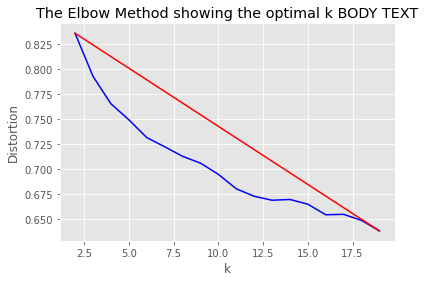

In [29]:
K = range(2, 20)
X_line = [K[0], K[-1]]
Y_line = [distortions_X1[0], distortions_X1[-1]]

# Plot the elbow
plt.plot(K, distortions_X1, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k BODY TEXT')
plt.show()

In [32]:
# pickle read X1_reduced
fileObject = open('pickled_X1_reduced2020-05-30.pickle', 'rb')
X1_reduced = pickle.load(fileObject)
fileObject.close()
X1_reduced


array([[ 0.2072846 , -0.02851574,  0.12498607, ...,  0.00889222,
        -0.00754477,  0.00453147],
       [-0.03517847,  0.13688483,  0.07768311, ...,  0.00395872,
         0.00028504, -0.00287766],
       [ 0.06208487,  0.10170393, -0.00743436, ..., -0.0040203 ,
         0.00112685, -0.00328545],
       ...,
       [-0.18000599, -0.09584603, -0.06494698, ..., -0.00332479,
         0.00641667, -0.00648128],
       [ 0.01216732,  0.04991847, -0.05731533, ...,  0.00086121,
        -0.00368344, -0.00318868],
       [-0.19247745, -0.11175269, -0.08188431, ...,  0.00217762,
        -0.00289335,  0.00550653]])

In [33]:
from sklearn.cluster import KMeans

k1 = 7
kmeans = KMeans(n_clusters=k1, random_state=42)
y1_pred = kmeans.fit_predict(X1_reduced)
y1_pred.shape


(22160,)

In [34]:
y1_df = pd.DataFrame(y1_pred)
y1_df

,0
0,0
1,5
2,0
3,5
4,2
...,...
22155,0
22156,6
22157,4
22158,6


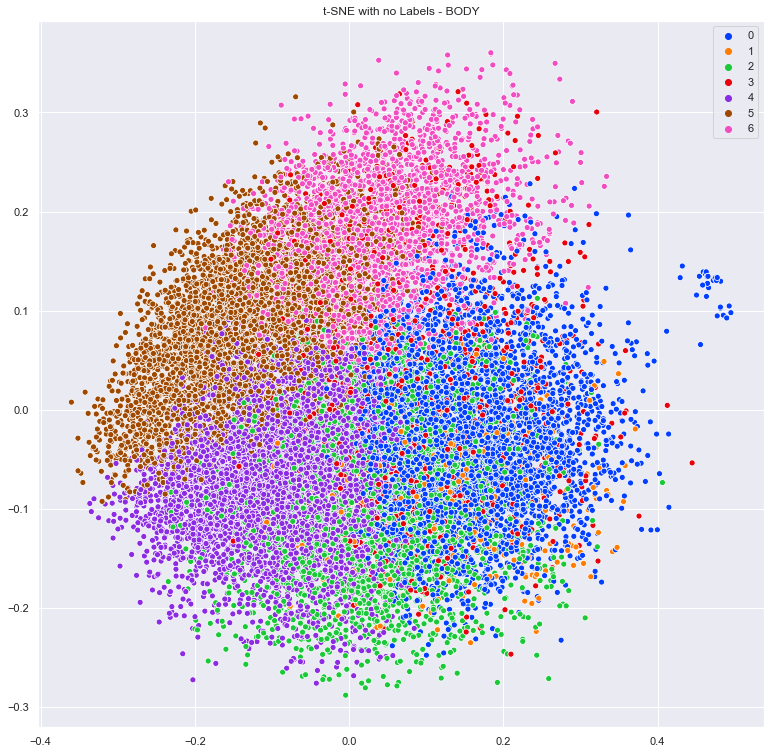

In [35]:
# sns settings
sn.set(rc={'figure.figsize':(13,13)})

# colors
palette = sn.color_palette("bright", k1)

# plot
sn.scatterplot(X1_reduced[:,0], X1_reduced[:,1], hue=y1_pred, palette=palette)
plt.title('t-SNE with no Labels - BODY')
plt.savefig("t-sne_covid19.png")
plt.show()

Applying the text-processing function on the body_text.

Let's take a look at word count in the papers

count    32417.000000
mean      1426.309005
std       1185.091529
min          1.000000
25%        911.000000
50%       1243.000000
75%       1667.000000
max      38298.000000
Name: body_unique_words, dtype: float64

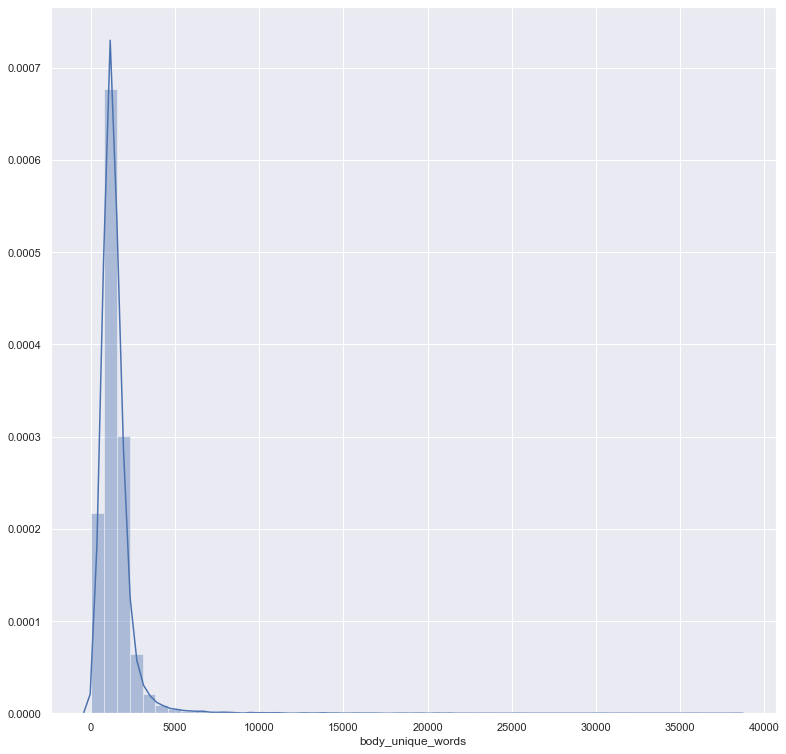

In [38]:
sn.distplot(df_covid['body_unique_words'])
df_covid['body_unique_words'].describe()

In [39]:
# # Pickled 

# df_covid = get_synonym_count(df_covid, 'body_text', synonym_dict)
# df_covid.head()

In [40]:
# # pickle write unsupervised_to_supervised

# date_of_launch = str(datetime.date.today())
# fileObject = open('pickled_unsupervised_to_supervised' + date_of_launch + '.pickle', 'wb')
# pickle.dump(df_covid, fileObject)
# fileObject.close()

In [41]:
# pickle read unsupervised_to_supervised
fileObject = open('pickled_unsupervised_to_supervised2020-06-01.pickle', 'rb')
unsupervised_to_supervised = pickle.load(fileObject)
fileObject.close()
df_covid = unsupervised_to_supervised
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,smoking,age,risk_factor,sex,bodyweight,diabetes,chronic_respiratory,immunity,asthma,climate,target
0,0015023cc06b5362d332b3baf348d11567ca2fbb,10.1101/2020.01.10.901801,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes. Chris<...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...,0,0,0,0,0,0,0,0,0,0,0
1,00340eea543336d54adda18236424de6a5e91c9d,10.1101/2020.03.16.20034470,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini. Costanza Manes...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir...",0,0,0,0,0,0,0,0,0,0,0
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,10.1101/2020.02.11.20022111,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang. Kaichen Tang. <br...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.,0,0,0,0,0,0,0,0,0,0,0
3,00911cf4f99a3d5ae5e5b787675646a743574496,10.1101/2020.03.26.009001,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,CHEER: hierarCHical taxonomic<br>classificati...,NaN,The fast accumulation of viral metagenomic<br...,0,3,0,0,0,0,0,0,0,0,0
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,10.1101/634600,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood. Jian Zhang....,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...,0,0,0,0,1,0,0,0,0,0,0


In [42]:
# # pickle

# covid19_synonyms = ['covid',
#                     'coronavirus disease 19',
#                     'sars cov 2', # Note that search function replaces '-' with ' '
#                     '2019 ncov',
#                     '2019ncov',
#                     r'2019 n cov\b',
#                     r'2019n cov\b',
#                     'ncov 2019',
#                     r'\bn cov 2019',
#                     'coronavirus 2019',
#                     'wuhan pneumonia',
#                     'wuhan virus',
#                     'wuhan coronavirus',
#                     r'coronavirus 2\b',
#                     'risk factor analysis',
#                     'cross sectional case control',
#                     'prospective case control',
#                     'matched case control',
#                     'medical records review',
#                     'seroprevalence survey',
#                     'syndromic surveillance',
#                     'corona', r'\bcov\b']

# for i in range(len(df_covid)):
#     count_all = 0
#     for synonym in covid19_synonyms:
#         count_all += df_covid['body_text'][i].count(synonym)
#     df_covid['target'][i] = count_all

# df_covid['target']

In [43]:
# # pickle

# # adding supervised data from unsupervised model
# data = {
#     'smoking': df_covid['smoking'], 
#     'age': df_covid['age'], 
#     'sex': df_covid['sex'], 
#     'bodyweight': df_covid['bodyweight'], 
#     'diabetes': df_covid['diabetes'], 
#     'chronic_respiratory': df_covid['chronic_respiratory'], 
#     'asthma': df_covid['asthma'], 
#     'immunity': df_covid['immunity'], 
#     'climate': df_covid['climate'], 
#     'target': df_covid['target']}

# df_synonyms = pd.DataFrame(data)

# # This removes all rows that have any features that are 0. This does not include the target.
# df_synonyms = df_synonyms[(df_synonyms[['smoking', 'age', 'sex', 'bodyweight', 'diabetes',
#        'chronic_respiratory', 'asthma', 'immunity', 'climate']] != 0).all(axis=1)]

# # # Remove all features if they all are zero. This does not remove target.
# # df_synonyms = df_synonyms.loc[~(df_synonyms[['smoking', 'age', 'sex', 'bodyweight', 'diabetes',
# #        'chronic_respiratory', 'asthma', 'immunity', 'climate']]==0).all(axis=1)]

# df_synonyms

In [44]:
# # pickle write df_synonyms

# date_of_launch = str(datetime.date.today())
# fileObject = open('pickled_df_synonyms' + date_of_launch + '.pickle', 'wb')
# pickle.dump(df_synonyms, fileObject)
# fileObject.close()

In [45]:
# pickle read text_analysis_supervised_dataset

fileObject = open('pickled_df_synonyms2020-06-02.pickle', 'rb')
df_synonyms = pickle.load(fileObject)
fileObject.close()
df_synonyms

,smoking,age,sex,bodyweight,diabetes,chronic_respiratory,asthma,immunity,climate,target
4354,7,84,22,27,29,6,4,1,11,12
5435,1,108,9,11,33,12,10,2,3,9
6904,98,910,72,66,5,1096,1090,17,62,3
10188,4,22,3,3,1,6,1,8,7,11
10507,24,15,11,9,9,1,1,1,2,0
12246,8,172,44,4,16,6,5,8,47,28
12449,38,372,32,19,30,668,661,13,6,11
12642,3,185,21,4,26,5,3,12,3,1
13197,2,75,1,1,2,6,5,2,2,4
13612,5,82,20,19,15,8,6,2,2,15


In [46]:
# Threshold value for target 
threshold = 3
len(df_synonyms.loc[df_synonyms['target'] > threshold])

26

In [47]:
# Binarize target
target_binary = []

for i, val in enumerate(df_synonyms['target']):
    if val > threshold:
        target_binary.append(1)
    else:
        target_binary.append(0)
df_synonyms['target_binary'] = target_binary
df_synonyms

,smoking,age,sex,bodyweight,diabetes,chronic_respiratory,asthma,immunity,climate,target,target_binary
4354,7,84,22,27,29,6,4,1,11,12,1
5435,1,108,9,11,33,12,10,2,3,9,1
6904,98,910,72,66,5,1096,1090,17,62,3,0
10188,4,22,3,3,1,6,1,8,7,11,1
10507,24,15,11,9,9,1,1,1,2,0,0
12246,8,172,44,4,16,6,5,8,47,28,1
12449,38,372,32,19,30,668,661,13,6,11,1
12642,3,185,21,4,26,5,3,12,3,1,0
13197,2,75,1,1,2,6,5,2,2,4,1
13612,5,82,20,19,15,8,6,2,2,15,1


In [48]:
# pre-processing dropping unnecessary feature

df_synonyms = df_synonyms.drop("target", axis=1)

In [49]:
# # classification

# X = df_synonyms.drop("target_binary", axis=1)
# y = target_binary
# decision_tree(X, y)
# # INSERT CORRECT PLOTTING FUNCTION

In [50]:
# df_X_y = pd.DataFrame(X)
# df_X_y['target'] = results
# df_X_y

In [51]:
defaulters_1=df_synonyms
defaulters_pearson_corr = defaulters_1.corr(method='pearson')
round(defaulters_pearson_corr, 3)

,smoking,age,sex,bodyweight,diabetes,chronic_respiratory,asthma,immunity,climate,target_binary
smoking,1.000,0.658,0.913,0.865,0.610,0.413,0.416,0.003,0.126,0.164
age,0.658,1.000,0.630,0.567,0.165,0.824,0.823,0.220,0.470,0.066
sex,0.913,0.630,1.000,0.880,0.652,0.293,0.298,-0.007,0.168,0.203
bodyweight,0.865,0.567,0.880,1.000,0.743,0.193,0.199,-0.049,0.059,0.143
diabetes,0.610,0.165,0.652,0.743,1.000,-0.073,-0.065,-0.169,-0.129,0.336
chronic_respiratory,0.413,0.824,0.293,0.193,-0.073,1.000,0.998,0.213,0.453,0.067
asthma,0.416,0.823,0.298,0.199,-0.065,0.998,1.000,0.170,0.421,0.051
immunity,0.003,0.220,-0.007,-0.049,-0.169,0.213,0.170,1.000,0.617,0.069
climate,0.126,0.470,0.168,0.059,-0.129,0.453,0.421,0.617,1.000,0.164
target_binary,0.164,0.066,0.203,0.143,0.336,0.067,0.051,0.069,0.164,1.000


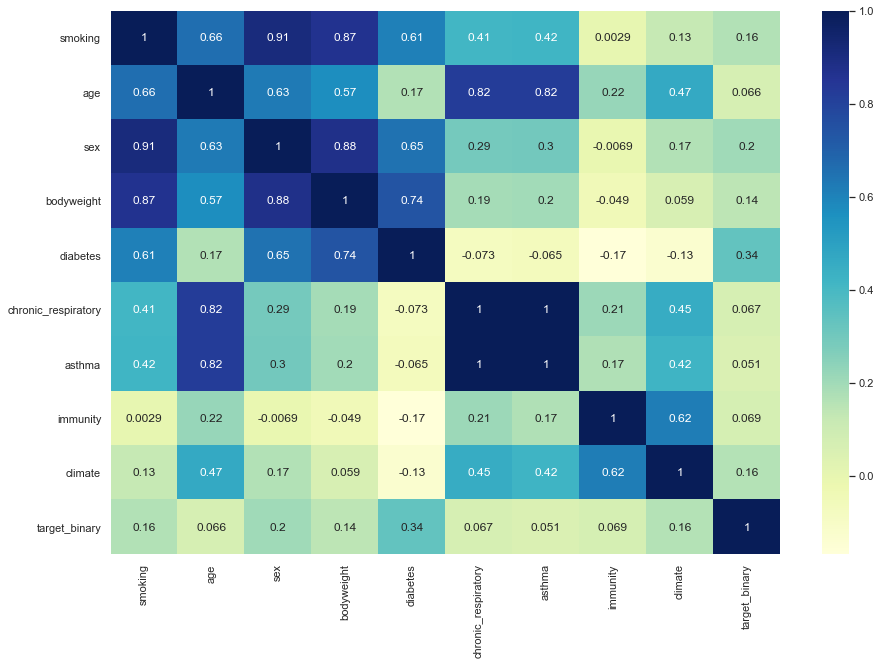

In [52]:
# figure size
plt.figure(figsize=(15,10))
# heatmap
sn.heatmap(defaulters_pearson_corr, cmap="YlGnBu", annot=True)
plt.show()

In [53]:
# Create abs correlation matrix
corr_matrix = defaulters_pearson_corr.abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
# Drop features 
df_synonyms_pearson = defaulters_1.drop(defaulters_1[to_drop], axis=1)
df_synonyms_pearson

,smoking,age,bodyweight,diabetes,chronic_respiratory,immunity,climate,target_binary
4354,7,84,27,29,6,1,11,1
5435,1,108,11,33,12,2,3,1
6904,98,910,66,5,1096,17,62,0
10188,4,22,3,1,6,8,7,1
10507,24,15,9,9,1,1,2,0
12246,8,172,4,16,6,8,47,1
12449,38,372,19,30,668,13,6,1
12642,3,185,4,26,5,12,3,0
13197,2,75,1,2,6,2,2,1
13612,5,82,19,15,8,2,2,1


In [54]:
pearson_cols = list(df_synonyms_pearson.columns)
pearson_cols.remove('target_binary')
pearson_cols

['smoking',
 'age',
 'bodyweight',
 'diabetes',
 'chronic_respiratory',
 'immunity',
 'climate']

In [55]:
# classification

X = df_synonyms_pearson.drop("target_binary", axis=1)
y = df_synonyms_pearson['target_binary']

# Split dataset into training set and test set
from sklearn.model_selection import train_test_split # Import train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #80% training and 20% test

In [56]:
from sklearn import metrics, tree
from sklearn.tree import export_graphviz, DecisionTreeClassifier # Import Decision Tree Classifier
import time

dtree = tree.DecisionTreeClassifier(criterion = "gini", splitter = 'random', max_leaf_nodes = 10, min_samples_leaf = 5, max_depth= 5)
# start timer
start = time.time()
dtree.fit(X_train,y_train)
# end timer
end = time.time()
print(f'time: {end - start}')

time: 0.19206023216247559


In [84]:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='random')

In [85]:
# start timer
start = time.time()
x_train_pred  = dtree.predict(X_train)
end = time.time()
print(f'time: {end - start}')
print("Accuracy:",metrics.accuracy_score(y_train, x_train_pred))

time: 0.0014259815216064453
Accuracy: 0.7714285714285715


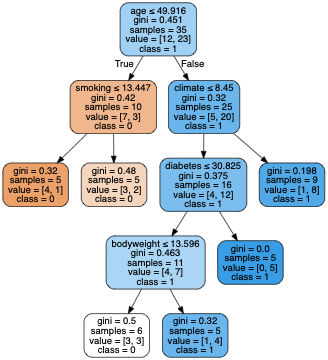

In [59]:
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(dtree, out_file=None, 
                     feature_names=pearson_cols,  
                     class_names=['0','1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  

# graph
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"9,5!"')
pydot_graph.write_png('resized_tree.png')

Image(pydot_graph.create_png())

In [60]:
# Create a Logistic Regression Object, perform Logistic Regression
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression()
start = time.time()
logistic_reg.fit(X_train, y_train)
end = time.time()
print(f'time: {end - start}')

time: 0.05522894859313965


In [61]:
# Perform prediction using the test dataset
from sklearn.metrics import confusion_matrix
y_pred = logistic_reg.predict(X_test)

# Show the Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4, 2],
       [1, 2]])

Accuracy: 0.6666666666666666
Precision: 0.5
Recall: 0.6666666666666666


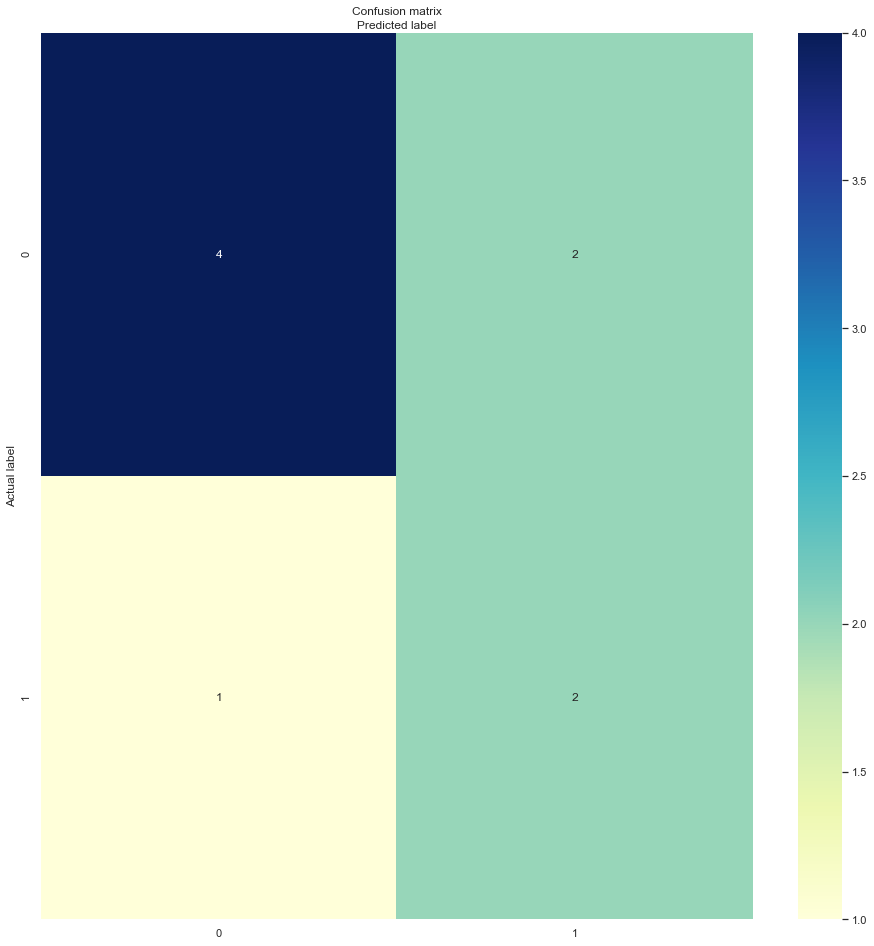

In [62]:
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [63]:
# Linear SVC
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y)

kfold = KFold(n_splits=10, random_state=42)
linear_svc = LinearSVC(max_iter=1000)
start = time.time()
results_linearsvc= cross_val_score(linear_svc, X, training_scores_encoded, cv=kfold, scoring='accuracy')
end = time.time()
print(f'time: {end - start}')
print('Estimate accuracy',results_linearsvc.mean())

time: 0.26784420013427734
Estimate accuracy 0.49000000000000005


In [64]:

from sklearn.ensemble import RandomForestClassifier

# Random Forest
kfold = KFold(n_splits=10, random_state=42)
random_forest = RandomForestClassifier(n_estimators=100)
start = time.time()
results_randomforest = cross_val_score(random_forest , X, training_scores_encoded, cv=kfold,scoring='accuracy')
end = time.time()
print(f'time: {end - start}')
print('Estimate accuracy',results_randomforest.mean())

time: 1.8862178325653076
Estimate accuracy 0.73


In [65]:
from sklearn.linear_model import Perceptron

# Perceptron
kfold = KFold(n_splits=10, random_state=42)
perceptron = Perceptron(max_iter=1000,tol=1e-3)
start = time.time()
results_perceptron = cross_val_score(perceptron, X, training_scores_encoded, cv=kfold,scoring='accuracy')
end = time.time()
print(f'time: {end - start}')
print('Estimate accuracy',results_perceptron.mean())

time: 0.14675402641296387
Estimate accuracy 0.505


In [66]:
start = time.time()
neural_network = neural_network_classification(X, y)
end = time.time()
print(f'time: {end - start}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
______________________________________

In [77]:
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

kfold = KFold(n_splits=5)

# create the sub models
estimators = []

# estimators.append(('logistic', logistic_reg))
estimators.append(('decision_tree', dtree))
estimators.append(('perceptron', perceptron))
estimators.append(('svm', linear_svc))
estimators.append(('random_forest', random_forest))
# estimators.append(('neural_network', neural_network))

# create the ensemble model
ensemble = VotingClassifier(estimators, weights=[2,1,1,1])
start = time.time()
results = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
end = time.time()
print(f'time: {end - start}')
print('ensemble accuracy: ', results.mean()) 

time: 1.0229618549346924
ensemble accuracy:  0.7472222222222221


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.417


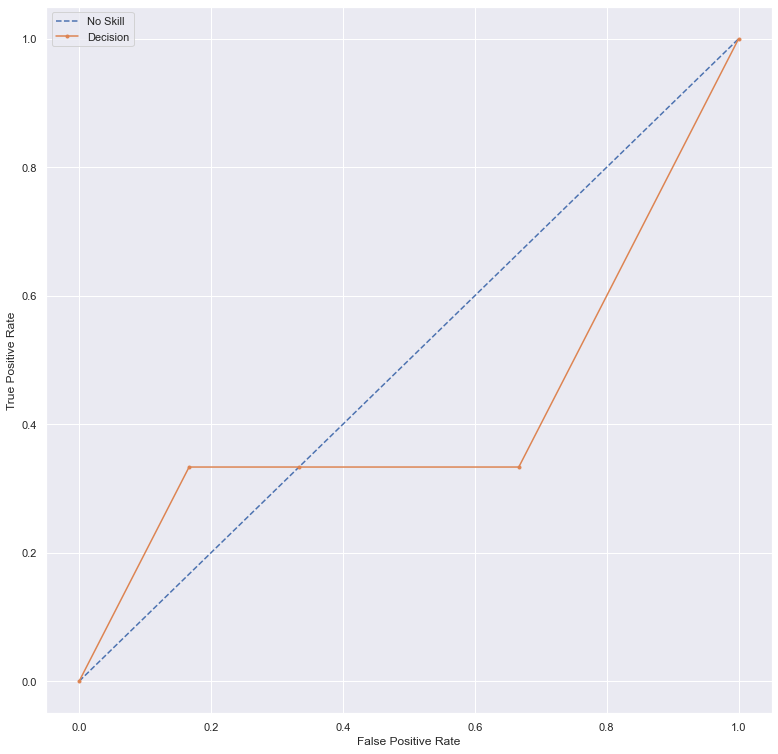

In [86]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = dtree.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()
# show the plot
pyplot.show()


# Crawl and Scrape Data from Maryland Institute

## Build DataFrame

In [69]:
# pickl read df_md_national

df_md_national = read_pickles('df_md_national', '2020-05-30')
df_md_national.head()

,Name,Social_distancing_index,%_staying_home,Trips/person,%_out-of-county_trips,%_out-of-state_trips,Miles/person,Work_trips/person,Non-work_trips/person,New_COVID_cases,...,COVID_death_rate,New_cases/1000_people,Active_cases/1000_people,#days:_decreasing_COVID_cases,%_hospital_bed_utilization,Testing_capacity,Tests_done/1000_people,%_ICU_utilization,Ventilator_shortage,Imported_COVID_cases
1,USA,53,31,2.48,27.5,4.9,30.2,0.24,2.23,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,12,0
2,USA,20,20,3.34,29.2,4.7,38.8,0.59,2.75,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,12,0
3,USA,16,19,3.51,29.4,4.7,40.8,0.59,2.93,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,2,0
4,USA,32,24,3.13,28.9,4.8,37.0,0.31,2.82,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,2,0
5,USA,45,28,2.72,27.7,4.9,33.8,0.26,2.46,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,2,0


# PRE-PROCESSING


In [70]:
df_md_national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 1 to 149
Data columns (total 41 columns):
Name                                     149 non-null object
Social_distancing_index                  148 non-null object
%_staying_home                           148 non-null object
Trips/person                             148 non-null object
%_out-of-county_trips                    148 non-null object
%_out-of-state_trips                     148 non-null object
Miles/person                             148 non-null object
Work_trips/person                        148 non-null object
Non-work_trips/person                    148 non-null object
New_COVID_cases                          148 non-null object
Population                               148 non-null object
%_change_in_consumption                  148 non-null object
date                                     148 non-null object
Transit_mode_share                       148 non-null object
%_people_older_than_60                   

In [71]:
df_md_national = df_md_national.dropna()
df_md_national

,Name,Social_distancing_index,%_staying_home,Trips/person,%_out-of-county_trips,%_out-of-state_trips,Miles/person,Work_trips/person,Non-work_trips/person,New_COVID_cases,...,COVID_death_rate,New_cases/1000_people,Active_cases/1000_people,#days:_decreasing_COVID_cases,%_hospital_bed_utilization,Testing_capacity,Tests_done/1000_people,%_ICU_utilization,Ventilator_shortage,Imported_COVID_cases
1,USA,53,31,2.48,27.5,4.9,30.2,0.24,2.23,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,12,0
2,USA,20,20,3.34,29.2,4.7,38.8,0.59,2.75,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,12,0
3,USA,16,19,3.51,29.4,4.7,40.8,0.59,2.93,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,2,0
4,USA,32,24,3.13,28.9,4.8,37.0,0.31,2.82,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,2,0
5,USA,45,28,2.72,27.7,4.9,33.8,0.26,2.46,0,...,0.0,0.0,0.0,0,51.66913535349564,0.0,0.0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,USA,38,26,3.13,27.5,4.4,32.2,0.25,2.89,21281,...,2.61,0.0713,2.15,24,56.30382660762416,11.7,42.09,13.96,10280,63873
145,USA,49,30,2.8,26.8,4.4,28.2,0.21,2.59,20320,...,2.61,0.0665,2.11,25,56.21112577954265,11.5,43.25,13.52,10035,56343
146,USA,50,31,2.69,27.2,4.6,29.7,0.24,2.46,19353,...,2.61,0.0621,2.07,26,56.12953640239851,11.3,44.59,13.42,9850,54589
147,USA,32,25,3.2,28.0,4.2,33.8,0.43,2.77,19094,...,2.61,0.0599,2.05,27,56.06976720571454,11.2,45.52,13.48,9698,60182


In [72]:
df_md_national['Name'].dtype

dtype('O')

In [95]:
df_md_national['Name'] = df_md_national['Name'].astype(object)
df_md_national['Social_distancing_index'] = df_md_national['Social_distancing_index'].astype(int)
df_md_national['%_staying_home'] = df_md_national['%_staying_home'].astype(int)
df_md_national['Trips/person'] = df_md_national['Trips/person'].astype(float)
# df_md_national['%_External_trips'] = df_md_national['%_External_trips'].astype(float)
df_md_national['Miles/person'] = df_md_national['Miles/person'].astype(float)
df_md_national['Work_trips/person'] = df_md_national['Work_trips/person'].astype(float)
df_md_national['Non-work_trips/person'] = df_md_national['Non-work_trips/person'].astype(float)
df_md_national['New_COVID_cases'] = df_md_national['New_COVID_cases'].astype(int)
df_md_national['Population'] = df_md_national['Population'].astype(int)
df_md_national['%_change_in_consumption'] = df_md_national['%_change_in_consumption'].astype(float)
df_md_national['date'] = df_md_national['date'].astype(object)
df_md_national['Transit_mode_share'] = df_md_national['Transit_mode_share'].astype(float)
df_md_national['%_people_older_than_60'] = df_md_national['%_people_older_than_60'].astype(int)
df_md_national['Median_income'] = df_md_national['Median_income'].astype(int)
df_md_national['%_African_Americans'] = df_md_national['%_African_Americans'].astype(float)
df_md_national['%_Hispanic_Americans'] = df_md_national['%_Hispanic_Americans'].astype(float)
df_md_national['%_Male'] = df_md_national['%_Male'].astype(float)
df_md_national['Population_density'] = df_md_national['Population_density'].astype(int)
df_md_national['Employment_density'] = df_md_national['Employment_density'].astype(int)
df_md_national['#_hot_spots/1000_people'] = df_md_national['#_hot_spots/1000_people'].astype(int)
df_md_national['Hospital_beds/1000_people'] = df_md_national['Hospital_beds/1000_people'].astype(float)
df_md_national['ICUs/1000_people'] = df_md_national['ICUs/1000_people'].astype(float)
df_md_national['%_hospital_bed_utilization'] = df_md_national['%_hospital_bed_utilization'].astype(float)
df_md_national['#_contact_tracing_workers/1000_people'] = df_md_national['#_contact_tracing_workers/1000_people'].astype(float)
df_md_national['COVID_exposure/1000_people'] = df_md_national['COVID_exposure/1000_people'].astype(float)
df_md_national['#days:_decreasing_ILI_cases'] = df_md_national['#days:_decreasing_ILI_cases'].astype(float)
df_md_national['Unemployment_claims/1000_people'] = df_md_national['Unemployment_claims/1000_people'].astype(float)
df_md_national['Unemployment_rate'] = df_md_national['Unemployment_rate'].astype(float)
df_md_national['%_working_from_home'] = df_md_national['%_working_from_home'].astype(float)
df_md_national['Cumulative_inflation_rate'] = df_md_national['Cumulative_inflation_rate'].astype(float)
df_md_national['COVID_death_rate'] = df_md_national['COVID_death_rate'].astype(float)
df_md_national['New_cases/1000_people'] = df_md_national['New_cases/1000_people'].astype(float)
df_md_national['Active_cases/1000_people'] = df_md_national['Active_cases/1000_people'].astype(float)
df_md_national['#days:_decreasing_COVID_cases'] = df_md_national['#days:_decreasing_COVID_cases'].astype(int)
df_md_national['Testing_capacity'] = df_md_national['Testing_capacity'].astype(float)
df_md_national['Tests_done/1000_people'] = df_md_national['Tests_done/1000_people'].astype(float)
df_md_national['%_ICU_utilization'] = df_md_national['%_ICU_utilization'].astype(float)
df_md_national['Ventilator_shortage'] = df_md_national['Ventilator_shortage'].astype(int)
df_md_national['Imported_COVID_cases'] = df_md_national['Imported_COVID_cases'].astype(int)


In [96]:
df_md_national['target'] = pd.cut(df_md_national['New_cases/1000_people'], bins=2, labels=np.arange(2), right=False)
df_md_national['target']

1      0
2      0
3      0
4      0
5      0
      ..
144    1
145    1
146    1
147    1
148    1
Name: target, Length: 148, dtype: category
Categories (2, int64): [0 < 1]

In [97]:
#calculating meta-data for application_data
app_meta_data=meta_data(df_md_national)
app_meta_data = app_meta_data.loc[app_meta_data['Unique'] != 1]
app_meta_data

,Total,Percent,Unique,Data_Type
COVID_death_rate,0,0.0,57,float64
COVID_exposure/1000_people,0,0.0,82,float64
#days:_decreasing_ILI_cases,0,0.0,15,float64
Unemployment_claims/1000_people,0,0.0,13,float64
Unemployment_rate,0,0.0,13,float64
%_working_from_home,0,0.0,11,float64
Cumulative_inflation_rate,0,0.0,5,float64
New_cases/1000_people,0,0.0,77,float64
Social_distancing_index,0,0.0,49,int64
Active_cases/1000_people,0,0.0,62,float64


In [98]:
cols= ['COVID_exposure/1000_people','#days:_decreasing_ILI_cases','Unemployment_claims/1000_people','Unemployment_rate','%_working_from_home',
       'Cumulative_inflation_rate','COVID_death_rate','Active_cases/1000_people','#days:_decreasing_COVID_cases',
       'Testing_capacity','Tests_done/1000_people','%_ICU_utilization','Ventilator_shortage','Imported_COVID_cases','Social_distancing_index',
       '%_staying_home','Trips/person','Miles/person','Work_trips/person','Non-work_trips/person','New_COVID_cases',
       '%_change_in_consumption']
# cols_2 = list(app_meta_data.columns)
# cols_2
app_meta_data.index.values.tolist()

['COVID_death_rate',
 'COVID_exposure/1000_people',
 '#days:_decreasing_ILI_cases',
 'Unemployment_claims/1000_people',
 'Unemployment_rate',
 '%_working_from_home',
 'Cumulative_inflation_rate',
 'New_cases/1000_people',
 'Social_distancing_index',
 'Active_cases/1000_people',
 '#days:_decreasing_COVID_cases',
 '%_hospital_bed_utilization',
 'Testing_capacity',
 'Tests_done/1000_people',
 '%_ICU_utilization',
 'Ventilator_shortage',
 'Imported_COVID_cases',
 '%_staying_home',
 'Trips/person',
 '%_out-of-county_trips',
 '%_out-of-state_trips',
 'Miles/person',
 'Work_trips/person',
 'Non-work_trips/person',
 'New_COVID_cases',
 '%_change_in_consumption',
 'date',
 'target']

In [99]:
defaulters_1=df_md_national[cols]
defaulters_pearson_corr = defaulters_1.corr(method='pearson')
round(defaulters_pearson_corr, 3)
# dcorr_parson = defaulters_1.corr(method ='pearson')
# dcorr_parson.iloc[1:25, :0]

,COVID_exposure/1000_people,#days:_decreasing_ILI_cases,Unemployment_claims/1000_people,Unemployment_rate,%_working_from_home,Cumulative_inflation_rate,COVID_death_rate,Active_cases/1000_people,#days:_decreasing_COVID_cases,Testing_capacity,...,Ventilator_shortage,Imported_COVID_cases,Social_distancing_index,%_staying_home,Trips/person,Miles/person,Work_trips/person,Non-work_trips/person,New_COVID_cases,%_change_in_consumption
COVID_exposure/1000_people,1.000,0.932,0.360,0.982,0.642,-0.954,0.969,0.948,0.777,-0.347,...,0.813,0.979,0.428,0.387,-0.343,-0.479,-0.440,-0.229,0.760,-0.229
#days:_decreasing_ILI_cases,0.932,1.000,0.460,0.950,0.716,-0.876,0.937,0.918,0.676,-0.307,...,0.839,0.922,0.460,0.436,-0.350,-0.519,-0.374,-0.274,0.803,-0.274
Unemployment_claims/1000_people,0.360,0.460,1.000,0.504,0.929,-0.397,0.467,0.460,0.019,-0.395,...,0.667,0.352,0.807,0.847,-0.735,-0.871,-0.389,-0.795,0.780,-0.795
Unemployment_rate,0.982,0.950,0.504,1.000,0.760,-0.947,0.987,0.971,0.684,-0.384,...,0.886,0.971,0.546,0.517,-0.455,-0.608,-0.471,-0.365,0.847,-0.365
%_working_from_home,0.642,0.716,0.929,0.760,1.000,-0.662,0.741,0.737,0.230,-0.457,...,0.866,0.644,0.819,0.837,-0.726,-0.896,-0.467,-0.741,0.920,-0.740
Cumulative_inflation_rate,-0.954,-0.876,-0.397,-0.947,-0.662,1.000,-0.941,-0.922,-0.675,0.450,...,-0.823,-0.943,-0.451,-0.414,0.365,0.515,0.446,0.257,-0.784,0.257
COVID_death_rate,0.969,0.937,0.467,0.987,0.741,-0.941,1.000,0.994,0.627,-0.375,...,0.910,0.980,0.525,0.491,-0.430,-0.596,-0.461,-0.337,0.861,-0.337
Active_cases/1000_people,0.948,0.918,0.460,0.971,0.737,-0.922,0.994,1.000,0.568,-0.354,...,0.932,0.969,0.532,0.499,-0.439,-0.608,-0.459,-0.352,0.870,-0.351
#days:_decreasing_COVID_cases,0.777,0.676,0.019,0.684,0.230,-0.675,0.627,0.568,1.000,-0.088,...,0.359,0.692,0.083,0.037,-0.044,-0.063,-0.276,0.093,0.324,0.093
Testing_capacity,-0.347,-0.307,-0.395,-0.384,-0.457,0.450,-0.375,-0.354,-0.088,1.000,...,-0.369,-0.338,-0.374,-0.380,0.334,0.404,0.249,0.321,-0.390,0.321


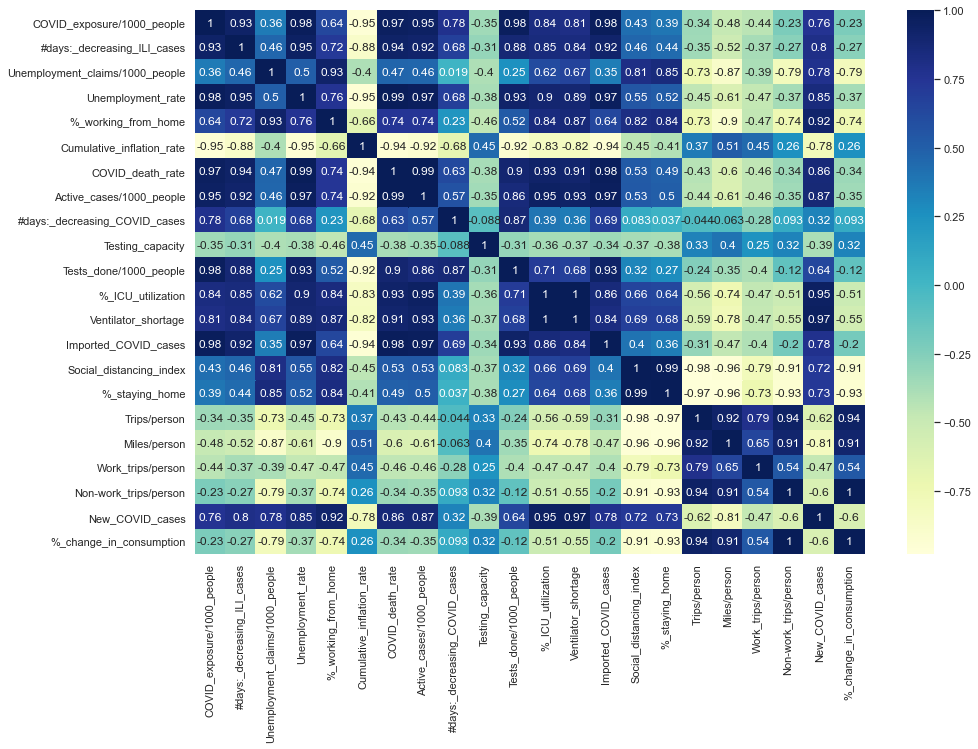

In [100]:
# figure size
plt.figure(figsize=(15,10))
# heatmap
sn.heatmap(defaulters_pearson_corr, cmap="YlGnBu", annot=True)
plt.show()

In [101]:
# Create abs correlation matrix
corr_matrix = defaulters_pearson_corr.abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.4
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
# Drop features 
meta_app_df_pearson = defaulters_1.drop(defaulters_1[to_drop], axis=1)
meta_app_df_pearson

,COVID_exposure/1000_people,Unemployment_claims/1000_people,#days:_decreasing_COVID_cases,Testing_capacity,Social_distancing_index,Work_trips/person
1,0.00,1.0,0,0.0,53,0.24
2,0.00,1.0,0,0.0,20,0.59
3,0.00,1.0,0,0.0,16,0.59
4,0.00,1.0,0,0.0,32,0.31
5,0.00,1.0,0,0.0,45,0.26
...,...,...,...,...,...,...
144,11.24,6.6,24,11.7,38,0.25
145,11.24,6.6,25,11.5,49,0.21
146,11.24,6.6,26,11.3,50,0.24
147,11.24,6.6,27,11.2,32,0.43


In [102]:
pearson_cols = list(meta_app_df_pearson.columns)
pearson_cols

['COVID_exposure/1000_people',
 'Unemployment_claims/1000_people',
 '#days:_decreasing_COVID_cases',
 'Testing_capacity',
 'Social_distancing_index',
 'Work_trips/person']

In [103]:
X = df_md_national[list(meta_app_df_pearson.columns)]
y = df_md_national.target

# Split dataset into training set and test set
from sklearn.model_selection import train_test_split # Import train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [104]:
from sklearn import metrics, tree
from sklearn.tree import export_graphviz, DecisionTreeClassifier # Import Decision Tree Classifier
import time

dtree = tree.DecisionTreeClassifier(criterion = "gini", splitter = 'random', max_leaf_nodes = 10, min_samples_leaf = 5, max_depth= 5)
# start timer
start = time.time()
dtree.fit(X_train,y_train)
# end timer
end = time.time()
print(f'time: {end - start}')

time: 0.010164022445678711


In [105]:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='random')

In [106]:
# start timer
start = time.time()
x_train_pred  = dtree.predict(X_train)
end = time.time()
print(f'time: {end - start}')
print("Accuracy:",metrics.accuracy_score(y_train, x_train_pred))

time: 0.0011150836944580078
Accuracy: 0.970873786407767


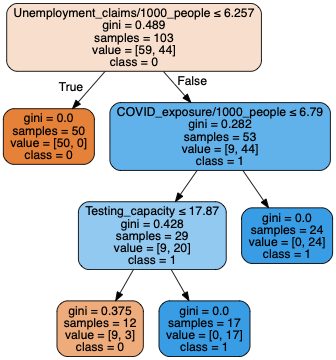

In [107]:
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(dtree, out_file=None, 
                     feature_names=pearson_cols,  
                     class_names=['0','1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  

# graph
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"9,5!"')
pydot_graph.write_png('resized_tree.png')

Image(pydot_graph.create_png())

In [108]:
# Create a Logistic Regression Object, perform Logistic Regression
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression()
start = time.time()
logistic_reg.fit(X_train, y_train)
end = time.time()
print(f'time: {end - start}')

time: 0.021410703659057617


In [109]:
# Perform prediction using the test dataset
from sklearn.metrics import confusion_matrix
y_pred = logistic_reg.predict(X_test)

# Show the Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix 

array([[28,  0],
       [ 0, 17]])

Text(0.5, 827.68, 'Predicted label')

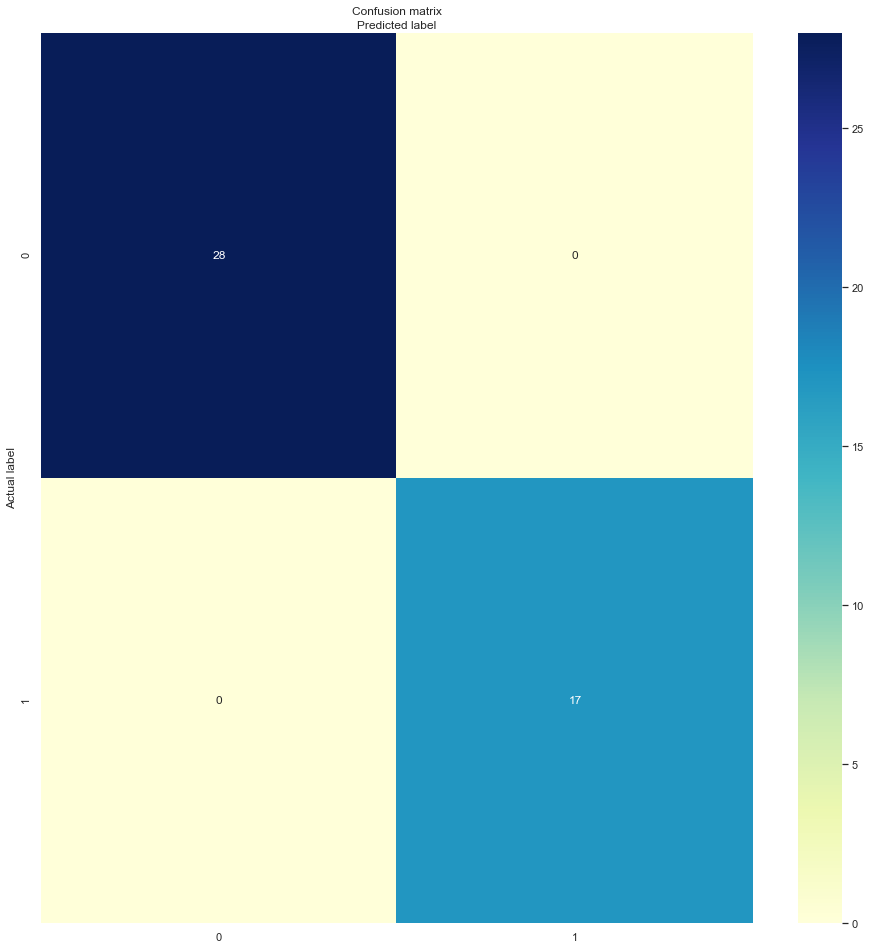

In [110]:
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [111]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [112]:
# Linear SVC
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y)

kfold = KFold(n_splits=10, random_state=42)
linear_svc = LinearSVC(max_iter=1000)
start = time.time()
results_linearsvc= cross_val_score(linear_svc, X, training_scores_encoded, cv=kfold, scoring='accuracy')
end = time.time()
print(f'time: {end - start}')
print('Estimate accuracy',results_linearsvc.mean())

time: 0.0840761661529541
Estimate accuracy 0.9266666666666665


In [113]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
kfold = KFold(n_splits=10, random_state=42)
random_forest = RandomForestClassifier(n_estimators=100)
start = time.time()
results_randomforest = cross_val_score(random_forest , X, training_scores_encoded, cv=kfold,scoring='accuracy')
end = time.time()
print(f'time: {end - start}')
print('Estimate accuracy',results_randomforest.mean())

time: 2.7952399253845215
Estimate accuracy 0.9933333333333334


In [114]:
from sklearn.linear_model import Perceptron

# Perceptron
kfold = KFold(n_splits=10, random_state=42)
perceptron = Perceptron(max_iter=1000,tol=1e-3)
start = time.time()
results_perceptron = cross_val_score(perceptron, X, training_scores_encoded, cv=kfold,scoring='accuracy')
end = time.time()
print(f'time: {end - start}')
print('Estimate accuracy',results_perceptron.mean())

time: 0.05277204513549805
Estimate accuracy 0.8666666666666668


In [115]:
start = time.time()
neural_network = neural_network_classification(X, y)
end = time.time()
print(f'time: {end - start}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
__________________________________

In [116]:
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

kfold = KFold(n_splits=10)

# create the sub models
estimators = []

# estimators.append(('logistic', logistic_reg))
estimators.append(('decision_tree', dtree))
estimators.append(('perceptron', perceptron))
estimators.append(('svm', linear_svc))
estimators.append(('random_forest', random_forest))
# estimators.append(('neural_network', neural_network))

# create the ensemble model
ensemble = VotingClassifier(estimators, weights=[2,1,1,2])
start = time.time()
results = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
end = time.time()
print(f'time: {end - start}')
print('ensemble accuracy: ', results.mean()) 
# print(results) 

time: 2.808318853378296
ensemble accuracy:  0.9533333333333334


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.983


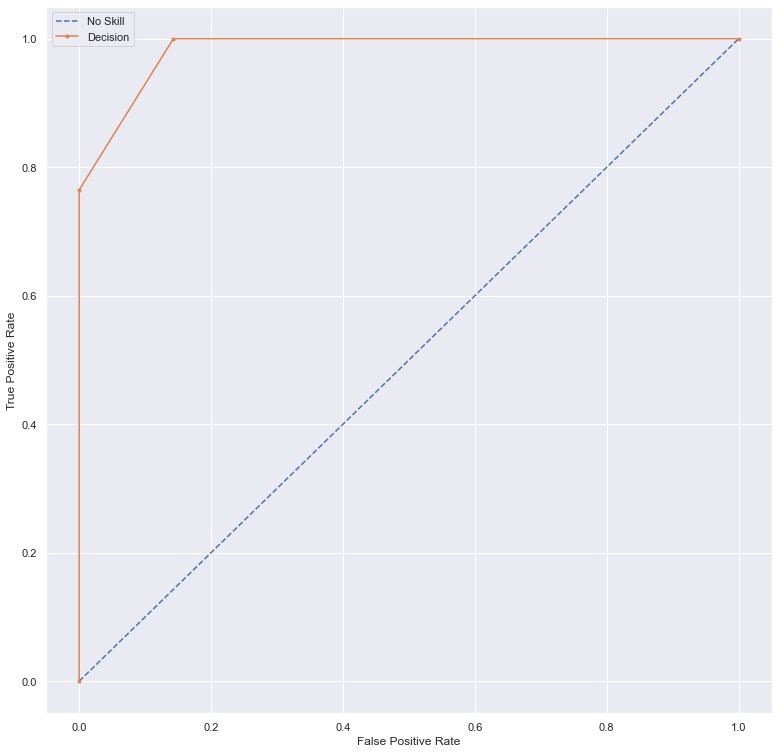

In [117]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = dtree.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()
# show the plot
pyplot.show()